#### Essayer d'apprendre les paramètres du ressort à partir des descripteurs des signaux pour avoir des coefs d'importance pour les descripteurs (poids à mettre pour le calcul des distance)

**Plan du notebook:**

**1.** Coefficients de corrélation

**2.** Régression linéaire pour apprendre les paramètres `F` et/ou `k`

**3.** Analyse en composante principales

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

import simu_ressort
import descriptor

In [2]:
all_simus = simu_ressort.load_obj("./data/ressort/simus.pkl")

print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['N']))
print("The duration of each simu is {} dt.".format(np.shape(all_simus[0]['simu'])[1]))

100 parameters tested, and 100 simus for each parameter.
The duration of each simu is 500 dt.


In [3]:
np.shape(all_simus[0]['simu'])

(100, 500)

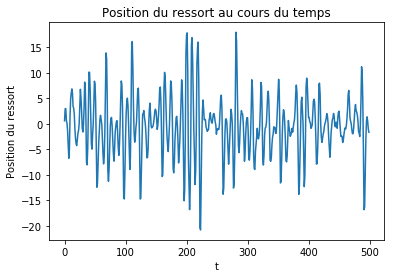

Descripteurs: [ -4.32503081e-01   5.91036307e+00  -2.07916021e+01   1.79335499e+01
   1.12000000e-01   1.06867136e+03]
-0.0731770748818


In [84]:
i = 20
V = all_simus[45]['simu'][i, :]
simu_ressort.plot_ressort(V)
desc = descriptor.compute_descriptor(V)
print("Descripteurs:", desc)
print(desc[0]/desc[1])

In [17]:
desc = []
for i in range(100):
    V = all_simus[0]['simu'][i, :]
    desc.append(descriptor.compute_descriptor(V))
    
desc = np.array(desc)

In [22]:
np.corrcoef(desc[:, 0], desc[:, 1])

array([[ 1.        ,  0.11536431],
       [ 0.11536431,  1.        ]])

### Preprocess data

In [123]:
nb_desc = len(descriptor.compute_descriptor([0]))
nb_simus = len(all_simus) * len(all_simus[0]['simu'])
print("{} descriptors and {} signals".format(nb_desc, nb_simus))

6 descriptors and 10000 signals


In [116]:
def preprocess_simu_to_numpy(all_simus):

    X_data = []
    Y_data = []

    for i in range(len(all_simus)):
        for j in range(len(all_simus[i]['simu'])):
            X_data.append(descriptor.compute_descriptor(all_simus[i]['simu'][j, :]))
            Y_data.append([all_simus[i]['F'], all_simus[i]['k']])
            
    return np.array(X_data), np.array(Y_data)

In [117]:
def separate_test_train(X_data, Y_data, pct_train=0.8):
    n_train = int(pct_train * len(X_data))
    
    X_train = X_data[:n_train, :]
    X_test = X_data[n_train:, :]    
    Y_train = Y_data[:n_train, :]    
    Y_test = Y_data[n_train:, :]
    
    return X_train, X_test, Y_train, Y_test

In [118]:
X_data, Y_data = preprocess_simu_to_numpy(all_simus)

# Mettre les variables à la même écheller
#X_data = StandardScaler().fit_transform(X_data)

print("Shape of X_data: {} and Y_data: {}".format(np.shape(X_data), np.shape(Y_data)))

X_train, X_test, Y_train, Y_test = separate_test_train(X_data, Y_data, pct_train=0.8)

Shape of X_data: (10000, 6) and Y_data: (10000, 2)


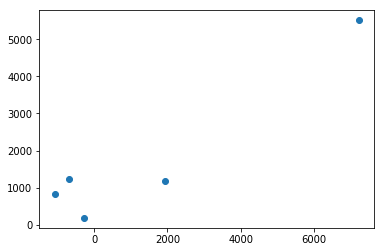

In [135]:
plt.scatter(X_data[:5, 0], X_data[:5, 1])
plt.show()

In [136]:
X_data[:5, 1]

array([  824.32106957,  1187.45279969,  1234.85961839,   185.30845586,
        5510.82757511])

In [137]:
desc_names = ['mean', 'std', 'min', 'max', 'fr_max', 'ampl_max']

In [138]:
X_df = pd.DataFrame(X_data)
X_df.columns = desc_names
X_df.describe()

,mean,std,min,max,fr_max,ampl_max
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04
mean,2.304323e+29,1.396452e+31,-1.540726e+32,2.266131e+32,0.039583,7.154235e+32
std,2.304323e+31,1.396452e+33,1.540726e+34,2.266131e+34,0.116124,7.154235e+34
min,-5.423051e+17,2.900772e+00,-1.540726e+36,-3.757024e+00,-0.248000,2.235502e+02
25%,-1.250652e-01,6.025247e+00,-4.270978e+01,2.071263e+01,-0.068000,7.137966e+02
50%,3.412615e-03,8.563496e+00,-2.769198e+01,2.776464e+01,0.082000,1.239245e+03
75%,1.298882e-01,1.470276e+01,-2.055597e+01,4.339531e+01,0.138000,3.234857e+03
max,2.304323e+33,1.396452e+35,3.947782e+00,2.266131e+36,0.252000,7.154235e+36


In [141]:
X_df['F'] = Y_data[:, 0]
X_df['k'] = Y_data[:, 1]

X_df.head()

,mean,std,min,max,fr_max,ampl_max,F,k
0,-1076.470108,824.321070,-2502.620208,60.453533,0.0,5.382351e+05,0.0,0.0
1,1938.589306,1187.452800,-4.455146,4378.073144,0.0,9.692947e+05,0.0,0.0
2,-688.186010,1234.859618,-4428.027625,372.626044,0.0,3.440930e+05,0.0,0.0
3,-282.574454,185.308456,-603.643486,41.855782,0.0,1.412872e+05,0.0,0.0
4,7226.871366,5510.827575,-3.033292,16682.678288,0.0,3.613436e+06,0.0,0.0


## 1. Coefficients de corrélation

In [143]:
X_df.corr()

,mean,std,min,max,fr_max,ampl_max,F,k
mean,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
std,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
min,-1.000000,-1.000000,1.000000,-1.000000,-0.018122,-1.000000,-1.566777e-02,-1.566777e-02
max,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
fr_max,0.018122,0.018122,-0.018122,0.018122,1.000000,0.018122,-8.336394e-02,1.320403e-01
ampl_max,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
F,0.015668,0.015668,-0.015668,0.015668,-0.083364,0.015668,1.000000e+00,-6.781781e-16
k,0.015668,0.015668,-0.015668,0.015668,0.132040,0.015668,-6.781781e-16,1.000000e+00


In [144]:
X_df['mean']

0      -1.076470e+03
1       1.938589e+03
2      -6.881860e+02
3      -2.825745e+02
4       7.226871e+03
5       3.425614e+03
6       1.702857e+03
7      -1.657274e+03
8      -4.986010e+02
9      -9.910519e+02
10     -2.337986e+03
11      1.020012e+03
12     -2.702945e+03
13     -1.572610e+03
14      4.699785e+03
15      3.056779e+03
16      5.936222e+02
17     -1.375344e+03
18      3.210586e+03
19     -6.475294e+01
20      1.245303e+03
21     -3.405637e+03
22      1.323057e+03
23      9.223227e+02
24     -3.299858e+03
25      2.034204e+03
26     -2.959617e+03
27     -3.964581e+03
28      1.739629e+03
29      3.419038e+03
            ...     
9970   -1.110250e-01
9971   -1.198753e-01
9972   -1.265339e-02
9973   -2.445706e-01
9974    3.698226e-02
9975   -1.275503e-01
9976    1.785687e-01
9977   -1.471296e-01
9978    1.089539e-01
9979   -1.609083e-01
9980   -2.246839e-01
9981    1.123987e-01
9982    8.876586e-02
9983    3.685263e-02
9984    2.920639e-02
9985    1.345589e-01
9986    1.056

**(Exemple:)**

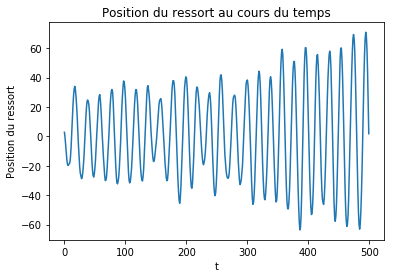

In [32]:
i = 10
data = np.array(all_simus[i]['simu'][4, :])
simu_ressort.plot_ressort(data, all_simus[i]['F'], all_simus[i]['k'])

In [33]:
print(descriptor.compute_descriptor(data))

[  1.07427236e+00   3.04897404e+01  -6.36288689e+01   7.09017869e+01
   5.00000000e-02   8.69675892e+03]


## 2. Apprendre `(F, k)` avec une regression linéaire
Pour trouver les poids des descripteurs

In [15]:
def train_regr_lin(X_train, Y_train, X_test, Y_test):
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)

    y_pred = regr.predict(X_test)
    print("MSE on test set:", mean_squared_error(y_pred, Y_test))

In [16]:
train_regr_lin(X_train, Y_train, X_test, Y_test)

MSE on test set: 2.47978983371e+21


Erreur assez chaud... 

A tester avec les coef de Fourrier 

#### Prédiction de `F`

In [17]:
train_regr_lin(X_train, Y_train[:, 0], X_test, Y_test[:, 0])

MSE on test set: 3.20138043367e+21


#### Prédiction de `k`

In [18]:
train_regr_lin(X_train, Y_train[:, 1], X_test, Y_test[:, 1])

MSE on test set: 1.75819922893e+21


## 3. ACP

In [19]:
from sklearn.decomposition import PCA

#### Projection en 2D

In [20]:
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(X_data)
principal_df = pd.DataFrame(data=principal_comp, columns=['principal component 1', 'principal component 2'])
principal_df['target'] = Y_data[:, 0]

In [21]:
principal_df.head()

,principal component 1,principal component 2,target
0,-0.025813,0.340642,0.0
1,-0.025813,0.340642,0.0
2,-0.025813,0.340642,0.0
3,-0.025813,0.340642,0.0
4,-0.025813,0.340642,0.0


In [22]:
pca.explained_variance_ratio_

array([ 0.83340174,  0.16659826])

-> La première composante contient 80% de la variance, et la deuxième 20%

In [23]:
pca.components_

array([[ 0.44719065,  0.44719065, -0.44719065,  0.44719065,  0.0101288 ,
         0.44719065],
       [ 0.00452974,  0.00452974, -0.00452974,  0.00452974, -0.9999487 ,
         0.00452974]])

-> Coordonnées des premières et deuxiemes composantes principales dans l'espace des descripteurs

ACP pour faire de la réduction de dimension: projetter sur un certains nb de composntes principales (nb < au nb de coord)

In [ ]:
import numpy as np

V = all_simus[0]['simu'][0,  :100]
print(V.shape)
freq = np.fft.fftfreq(len(V))

In [ ]:
freq

In [ ]:
signal = np.fft.fft(V)

In [ ]:
signal

In [ ]:
fr_max = freq[np.argmax(signal)]
fr_max